In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)
tf.global_variables_initializer().run(session=session)
tf.local_variables_initializer().run(session=session)



In [7]:
from keras.models import load_model

model = load_model("gz_dev.model")
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22, 15)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 22, 10)       160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 22, 10)       0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 22, 8)        88          leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [3]:
import random
import numpy as np

from trainingHelper import TrainingHelper
from trainingGame import loadTrainingGame
from mapHelper import mapHelper
import nnHelper

from os import listdir
from os.path import isfile, join

filepath = "D:/GalconZero/Games"

TRAINING_CACHE_SUFFIX = ".npz"
TRAINING_GAME_SUFFIX = ".pickle"
BATCH_SIZE = 128 #2048

def createTrainCacheFile(trainingFile):
    trainingGame = loadTrainingGame(trainingFile)
    helper = TrainingHelper(trainingGame)    
    exampleState = trainingGame.states[0]
    mapHelper.setItems(exampleState)
    
    
    trainX = helper.getTrainX()
    trainPolicy, trainValue = helper.getTrainY()
    
    trainingCacheFile = trainingFile.replace(TRAINING_GAME_SUFFIX, TRAINING_CACHE_SUFFIX)
    
    np.savez(trainingCacheFile, trainX=trainX, trainPolicy=trainPolicy, trainValue=trainValue)

def fetchTrainXY(trainingFile):
    trainingCacheFile = trainingFile.replace(TRAINING_GAME_SUFFIX, TRAINING_CACHE_SUFFIX)
    if not isfile(trainingCacheFile):
        createTrainCacheFile(trainingFile)
        
    npzFile = np.load(trainingCacheFile)
#     print('loaded ' + trainingCacheFile)
    return npzFile['trainX'], npzFile['trainPolicy'], npzFile['trainValue']
            
# def getTrainingDataForNumGames(num=-1):
#     onlyFiles = [f for f in listdir(filepath) if isfile(join(filepath, f)) and TRAINING_GAME_SUFFIX in f]
 
#     trainX = np.empty((0, 22, 14))
#     trainY = [np.empty((0, 925)), np.empty((0,))]

#     filenames = onlyFiles if num==-1 else random.sample(onlyFiles, num)
#     for filename in filenames:
#     #     print("loading training file {}".format(filename))
#         nextTrainX, policy, value = fetchTrainXY(filepath + "/" + filename)
        
#         #twice, once for regular, once for flipped Y values
#         trainX = np.concatenate((trainX, nextTrainX))
#         trainX = np.concatenate((trainX, getXAxisReflectedTrainingData(nextTrainX)))

#         #twice, once for regular, once for flipped Y values (reflecting over x axis does not change policy or value)
#         trainY = [np.concatenate((trainY[0], policy)), np.concatenate((trainY[1], value))]
#         trainY = [np.concatenate((trainY[0], policy)), np.concatenate((trainY[1], value))]

#     print("Finished loading {} training files".format(num))
#     return trainX, trainY

def getTrainingDataForNumGames(num=-1):
    onlyFiles = [f for f in listdir(filepath) if isfile(join(filepath, f)) and TRAINING_GAME_SUFFIX in f]
 
    NUM_VALIDATION_FILES = 10
    
    valTrainX = []
    valYPolicy = []
    valYValue = []
    trainX = []
    trainPolicy = []
    trainValue = []
    
    # reserve 20 games worth of files for validation only
    validationFilenames = onlyFiles[len(onlyFiles) - NUM_VALIDATION_FILES:]
    for filename in validationFilenames:
    #     print("loading training file {}".format(filename))
        nextTrainX, policy, value = fetchTrainXY(filepath + "/" + filename)
        
        #twice, once for regular, once for flipped Y values
        valTrainX.extend(nextTrainX)
        valTrainX.extend(getXAxisReflectedTrainingData(nextTrainX))

        #twice, once for regular, once for flipped Y values (reflecting over x axis does not change policy or value)
        valYPolicy.extend(policy)
        valYPolicy.extend(policy)
        valYValue.extend(value)
        valYValue.extend(value)
    
    
    
    trainFilenames = onlyFiles[:len(onlyFiles) - NUM_VALIDATION_FILES]
    
    filenames = trainFilenames if num==-1 else random.sample(trainFilenames, num)
    for filename in filenames:
    #     print("loading training file {}".format(filename))
        nextTrainX, policy, value = fetchTrainXY(filepath + "/" + filename)
        
        #twice, once for regular, once for flipped Y values
        trainX.extend(nextTrainX)
        trainX.extend(getXAxisReflectedTrainingData(nextTrainX))

        #twice, once for regular, once for flipped Y values (reflecting over x axis does not change policy or value)
        trainPolicy.extend(policy)
        trainPolicy.extend(policy)
        trainValue.extend(value)
        trainValue.extend(value)

    valTrainX = np.array(valTrainX[::10])
    valYPolicy = np.array(valYPolicy[::10])
    valYValue = np.array(valYValue[::10])
    trainX = np.array(trainX)
    trainPolicy = np.array(trainPolicy)
    trainValue = np.array(trainValue)
    
    print("Finished loading {} training files and {} validation files".format(len(filenames), len(validationFilenames)))
    return trainX, [trainPolicy, trainValue], valTrainX, [valYPolicy, valYValue]

def trainingLoop(numGamesPerLoop, numEpochs):
    trainX, [trainYPolicy, trainYValue], valTrainX, [valYPolicy, valYValue] = getTrainingDataForNumGames(numGamesPerLoop)
    
    indices = np.arange(len(trainX))
    randomSubsetIndices = np.random.choice(indices, size=int(len(trainX)/10), replace=False)
    
    trainX = np.take(trainX, randomSubsetIndices, axis=0)
    trainYPolicy = np.take(trainYPolicy, randomSubsetIndices, axis=0)  
    trainYValue = np.take(trainYValue, randomSubsetIndices, axis=0)
    
    return model.fit(trainX, [trainYPolicy, trainYValue], validation_data=(valTrainX, [valYPolicy, valYValue]), epochs=numEpochs, shuffle=True, batch_size=BATCH_SIZE)

def getXAxisReflectedTrainingData(data):
    data = data.copy()
    for sample in data:
        for row in sample:
            row[8] *= -1
            row[11] *= -1
            row[14] *= -1
    return data


In [4]:
historyPolicyValAcc = []
historyValueValAcc = []

historyPolicyValLoss = []
historyValueValLoss = []
historyValLoss = []

def doTrain(num_loops, numGamesPerLoop,numEpochs=1):
    for i in range(num_loops):
        history = trainingLoop(numGamesPerLoop, numEpochs)

        historyPolicyValAcc.extend(history.history['val_policy_acc'])
        historyValueValAcc.extend(history.history['val_value_acc'])
        
        historyPolicyValLoss.extend(history.history['val_policy_loss'])
        historyValueValLoss.extend(history.history['val_value_loss'])
        historyValLoss.extend(history.history['val_loss'])


In [ ]:
# import tensorflow as tf

# doTrain(num_loops=1000, numGamesPerLoop=100)

# for some dumb reason, I have to do this suddenly
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    # for some dumb reason, this fails the first time
doTrain(num_loops=100, numGamesPerLoop=20,numEpochs=1)




Finished loading 20 training files and 10 validation files
Train on 1082 samples, validate on 478 samples
Epoch 1/1
1082/1082 [==============================] - 0s 112us/step - loss: 10.0415 - policy_loss: 3.5222 - value_loss: 0.6519 - policy_acc: 0.2532 - value_acc: 0.6054 - val_loss: 11.5917 - val_policy_loss: 4.7759 - val_value_loss: 0.6816 - val_policy_acc: 0.0314 - val_value_acc: 0.5669
Finished loading 20 training files and 10 validation files
Train on 1026 samples, validate on 428 samples
Epoch 1/1
1026/1026 [==============================] - 0s 107us/step - loss: 9.7140 - policy_loss: 3.7794 - value_loss: 0.5935 - policy_acc: 0.2222 - value_acc: 0.6501 - val_loss: 12.0404 - val_policy_loss: 4.3059 - val_value_loss: 0.7735 - val_policy_acc: 0.0841 - val_value_acc: 0.4766
Finished loading 20 training files and 10 validation files
Train on 1080 samples, validate on 307 samples
Epoch 1/1
1080/1080 [==============================] - 0s 99us/step - loss: 9.2621 - policy_loss: 3.2572 

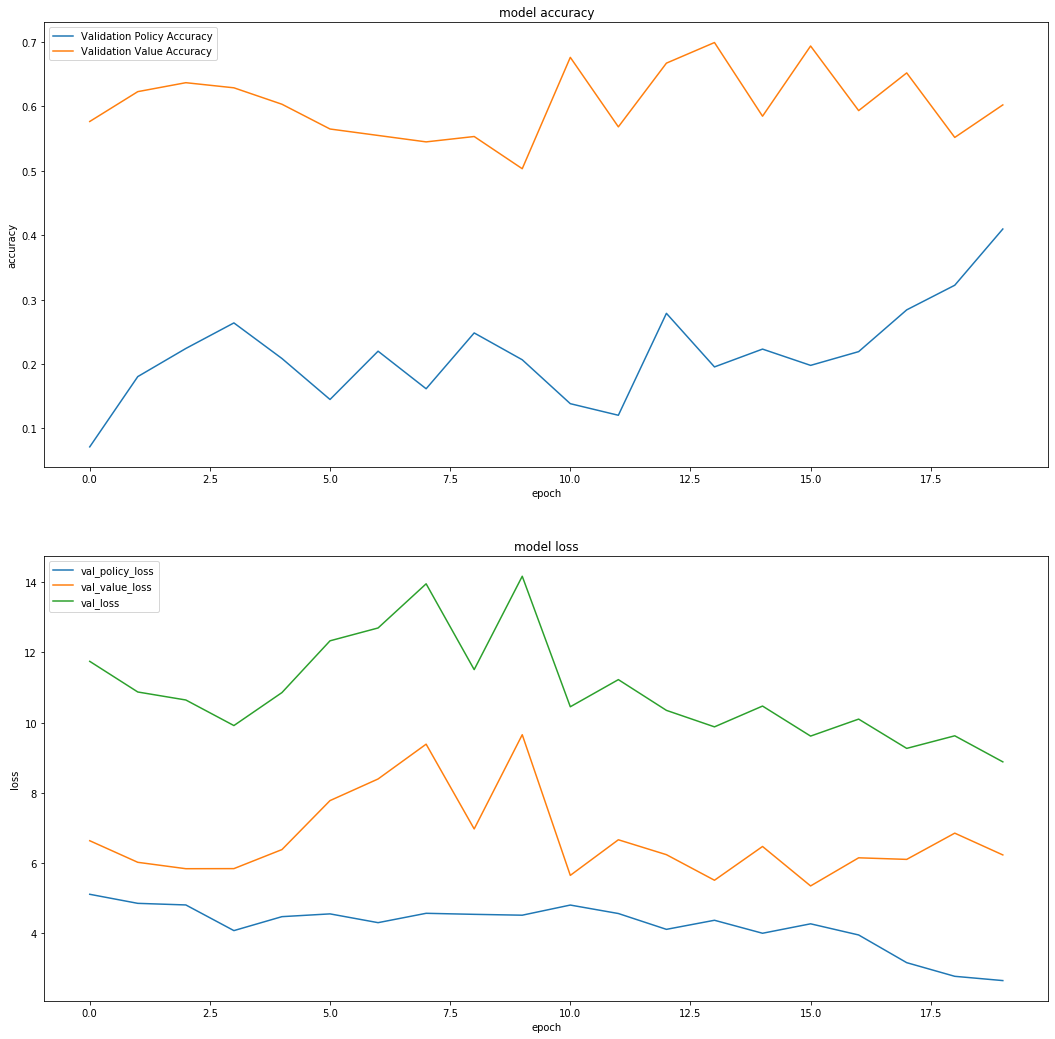

In [12]:
import matplotlib.pyplot as plt 
    
plt.figure(1, figsize=(18, 18))
   
# summarize history for accuracy  
   
plt.subplot(211)  
# plt.plot(history.history['policy_acc'])  
plt.plot(historyPolicyValAcc)  
# plt.plot(history.history['value_acc'])  
plt.plot(historyValueValAcc)  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
# plt.legend(['policy_categorical_accuracy', 'val_policy_categorical_accuracy', 'value_categorical_accuracy', 'val_value_categorical_accuracy'], loc='upper left')  
plt.legend(['Validation Policy Accuracy','Validation Value Accuracy'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(historyPolicyValLoss)  
plt.plot([x * 10 for x in historyValueValLoss])  
plt.plot(historyValLoss)   
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
# plt.legend(['policy_loss', 'val_policy_loss', 'value_loss','val_value_loss','loss','val_loss',], loc='upper left')  
plt.legend(['val_policy_loss','val_value_loss','val_loss'], loc='upper left')  

plt.show()  

In [36]:
# save model and proceed to next iteration

import re
from os import listdir
from os.path import isfile, join

# find highest iteration model 

filepath = '.'

onlyFiles = [f for f in listdir(filepath) if isfile(join(filepath, f)) and 'iter' in f]
highestIteration = max([int(re.findall(r'\d+', filename)[0]) for filename in onlyFiles], key=lambda iterNum: int(iterNum))

newModelFileName = 'gz_dev.iter{0}.model'.format(highestIteration + 1)
print(newModelFileName)

model.save("gz_dev.model")
model.save(newModelFileName)

gz_dev.iter1.model


In [4]:
from trainingGame import loadTrainingGame
from trainingHelper import TrainingHelper
from mapHelper import mapHelper

game = loadTrainingGame("testGame.pickle")
exampleState = game.states[0]
mapHelper.setItems(exampleState)
helper = TrainingHelper(game) 

trainX = helper.getTrainX()


In [13]:
print(trainX[299])

[[ 0.          1.          0.          0.          0.5         0.
   0.24       -2.08        0.32        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.67        0.          0.          0.          0.
   0.19       -1.52        0.1         0.06       -1.38        0.065
   0.          0.          0.        ]
 [ 0.          0.62        0.          0.          1.88        0.
   0.18       -1.46       -1.29        0.          0.          0.
   0.01       -1.11       -1.12      ]
 [ 0.          0.58        0.          0.          0.02        0.
   0.18       -1.45        1.32        0.          0.          0.
   0.          0.          0.        ]
 [ 0.95        0.          0.          0.01        0.          0.
   0.23       -1.37       -0.72        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.34        0.          0.          0.17
   0.14       -1.07        0.3         0.08       -1.11875     0.055
   0.

In [20]:
import numpy as np
a = model.predict(np.array([trainX[0]]))
a[1][0][0]

0.62095207